# cluster analysis

In [9]:
import json 
path="/home/flowers/work/text-clustering/archive/preprocess_p3_emb.json"
with open(path) as f:
    dat=json.load(f)

In [11]:
len(dat)

549

In [3]:
from src.text_clustering import ClusterClassifier
cc = ClusterClassifier(
    embed_device="cuda",
    topic_mode="single_topic",
    summary_template="",
    summary_instruction="",
    dbscan_eps=0.08,
    dbscan_min_samples=4,
    fast_init=True
)
cc.load("./aces_test")

import pandas as pd
import textwrap
import matplotlib.pyplot as plt
df = pd.DataFrame(
    data={
        "X": cc.projections[:, 0],
        "Y": cc.projections[:, 1],
        "labels": cc.cluster_labels,
        "content_display": [
            textwrap.fill(txt[:1024], 64) for txt in cc.texts
        ],
    }
)
cc.cluster_summaries

{-1: 'None',
 0: 'recursion, string manipulation, conditional logic',
 1: 'python programming, number theory, mathematical operations',
 2: 'recursion, mathematical operations',
 3: 'list manipulation, randomization, conditional logic',
 4: 'sudoku validation, list compre',
 5: 'recursion, mathematical operations, conditional logic',
 6: 'list manipulation, arithmetic sequence detection',
 7: 'string manipulation, reverse strings, assertions',
 8: 'mathematical operations, conditional logic, prime numbers',
 9: 'dynamic programming, coin change problem, minimization',
 10: 'string manipulation, reverse functions, assertions',
 11: 'recursion, permutations, conditional logic',
 12: 'prime numbers, number theory, random number generation',
 13: 'recursion, string manipulation, conditional logic',
 14: 'list manipulation, mathematical operations, conditional logic',
 15: 'prime numbers, sympy, list com',
 16: 'recursion, fibonacci',
 17: 'anagrams, set operations, list manipulation',
 18:

In [4]:
cluster_data = []
for cluster_id in cc.label2docs.keys():
    if cluster_id == -1:
        continue

    # inference mode
    doc_ids = cc.label2docs[cluster_id]
    examples = [cc.texts[doc_id] for doc_id in doc_ids]

    cluster_info = {
        "cluster_id": cluster_id,
        "summary": cc.cluster_summaries[cluster_id],
        "examples": examples,
    }


    cluster_info["position"] = cc.cluster_centers[cluster_id]

    cluster_data.append(cluster_info)

ps=pd.DataFrame(cluster_data)


/tmp/ipykernel_17455/1494315730.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_17455/1494315730.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


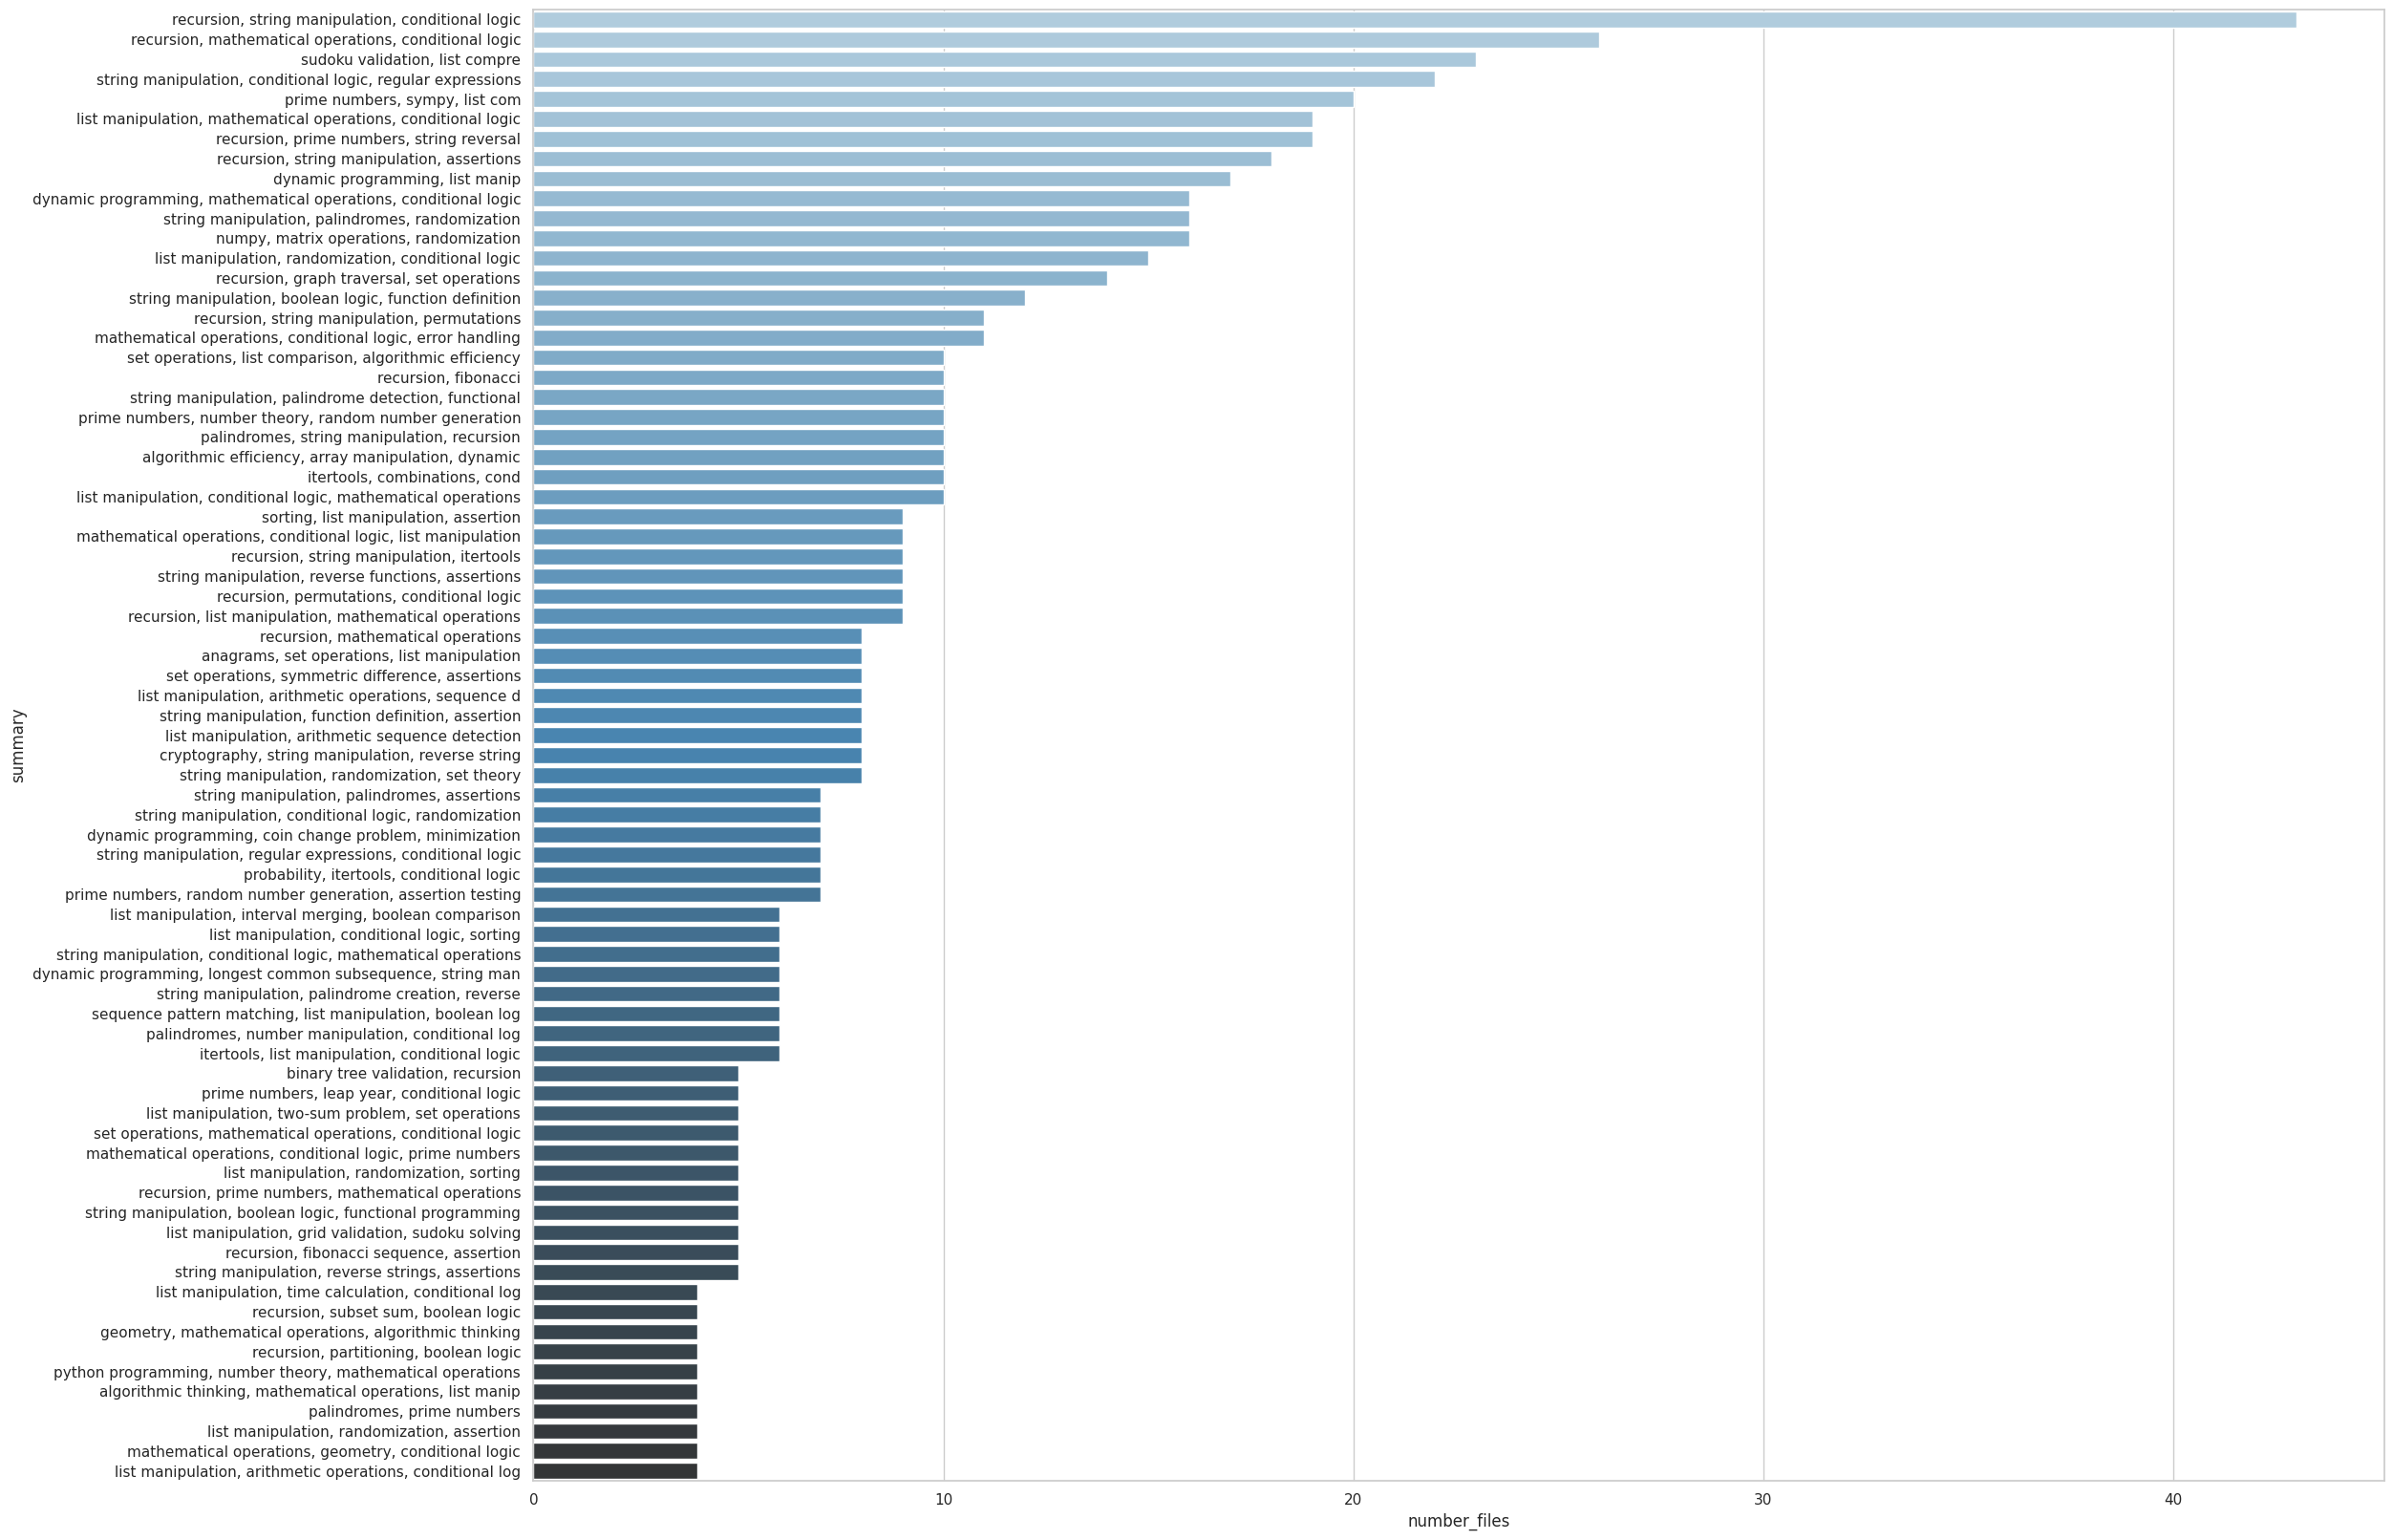

In [5]:
import seaborn as sns
ps = ps.explode("examples")
sorted_filtered_ds = ps.groupby(by="summary").size().sort_values(ascending=False)
category_df = sorted_filtered_ds.reset_index()
category_df.columns = ["summary", "number_files"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(25, 20))

barplot = sns.barplot(
    x="number_files", y="summary", data=category_df, palette="Blues_d", ci=None
)

In [7]:
import plotly.express as px

fig = px.scatter(
    df,
    x="X",
    y="Y",
    color="labels",
    hover_data={"content_display": True, "X": False, "Y": False},
    width=1600,
    height=800,
    color_continuous_scale="HSV",
)

fig.update_traces(hovertemplate="%{customdata[0]}<extra></extra>")

fig.update_traces(
    marker=dict(size=5, opacity=0.8),  # color="white"
    selector=dict(mode="markers"),
)

# fig.update_layout(
#     template="plotly_dark",
# )

# show cluster summaries
for label in cc.cluster_summaries.keys():
    if label == -1:
        continue
    summary = cc.cluster_summaries[label]
    position = cc.cluster_centers[label]

    fig.add_annotation(
        x=position[0],
        y=position[1],
        text=summary.split("Educational")[0],
        showarrow=False,
        yshift=0,
    )

fig.show()

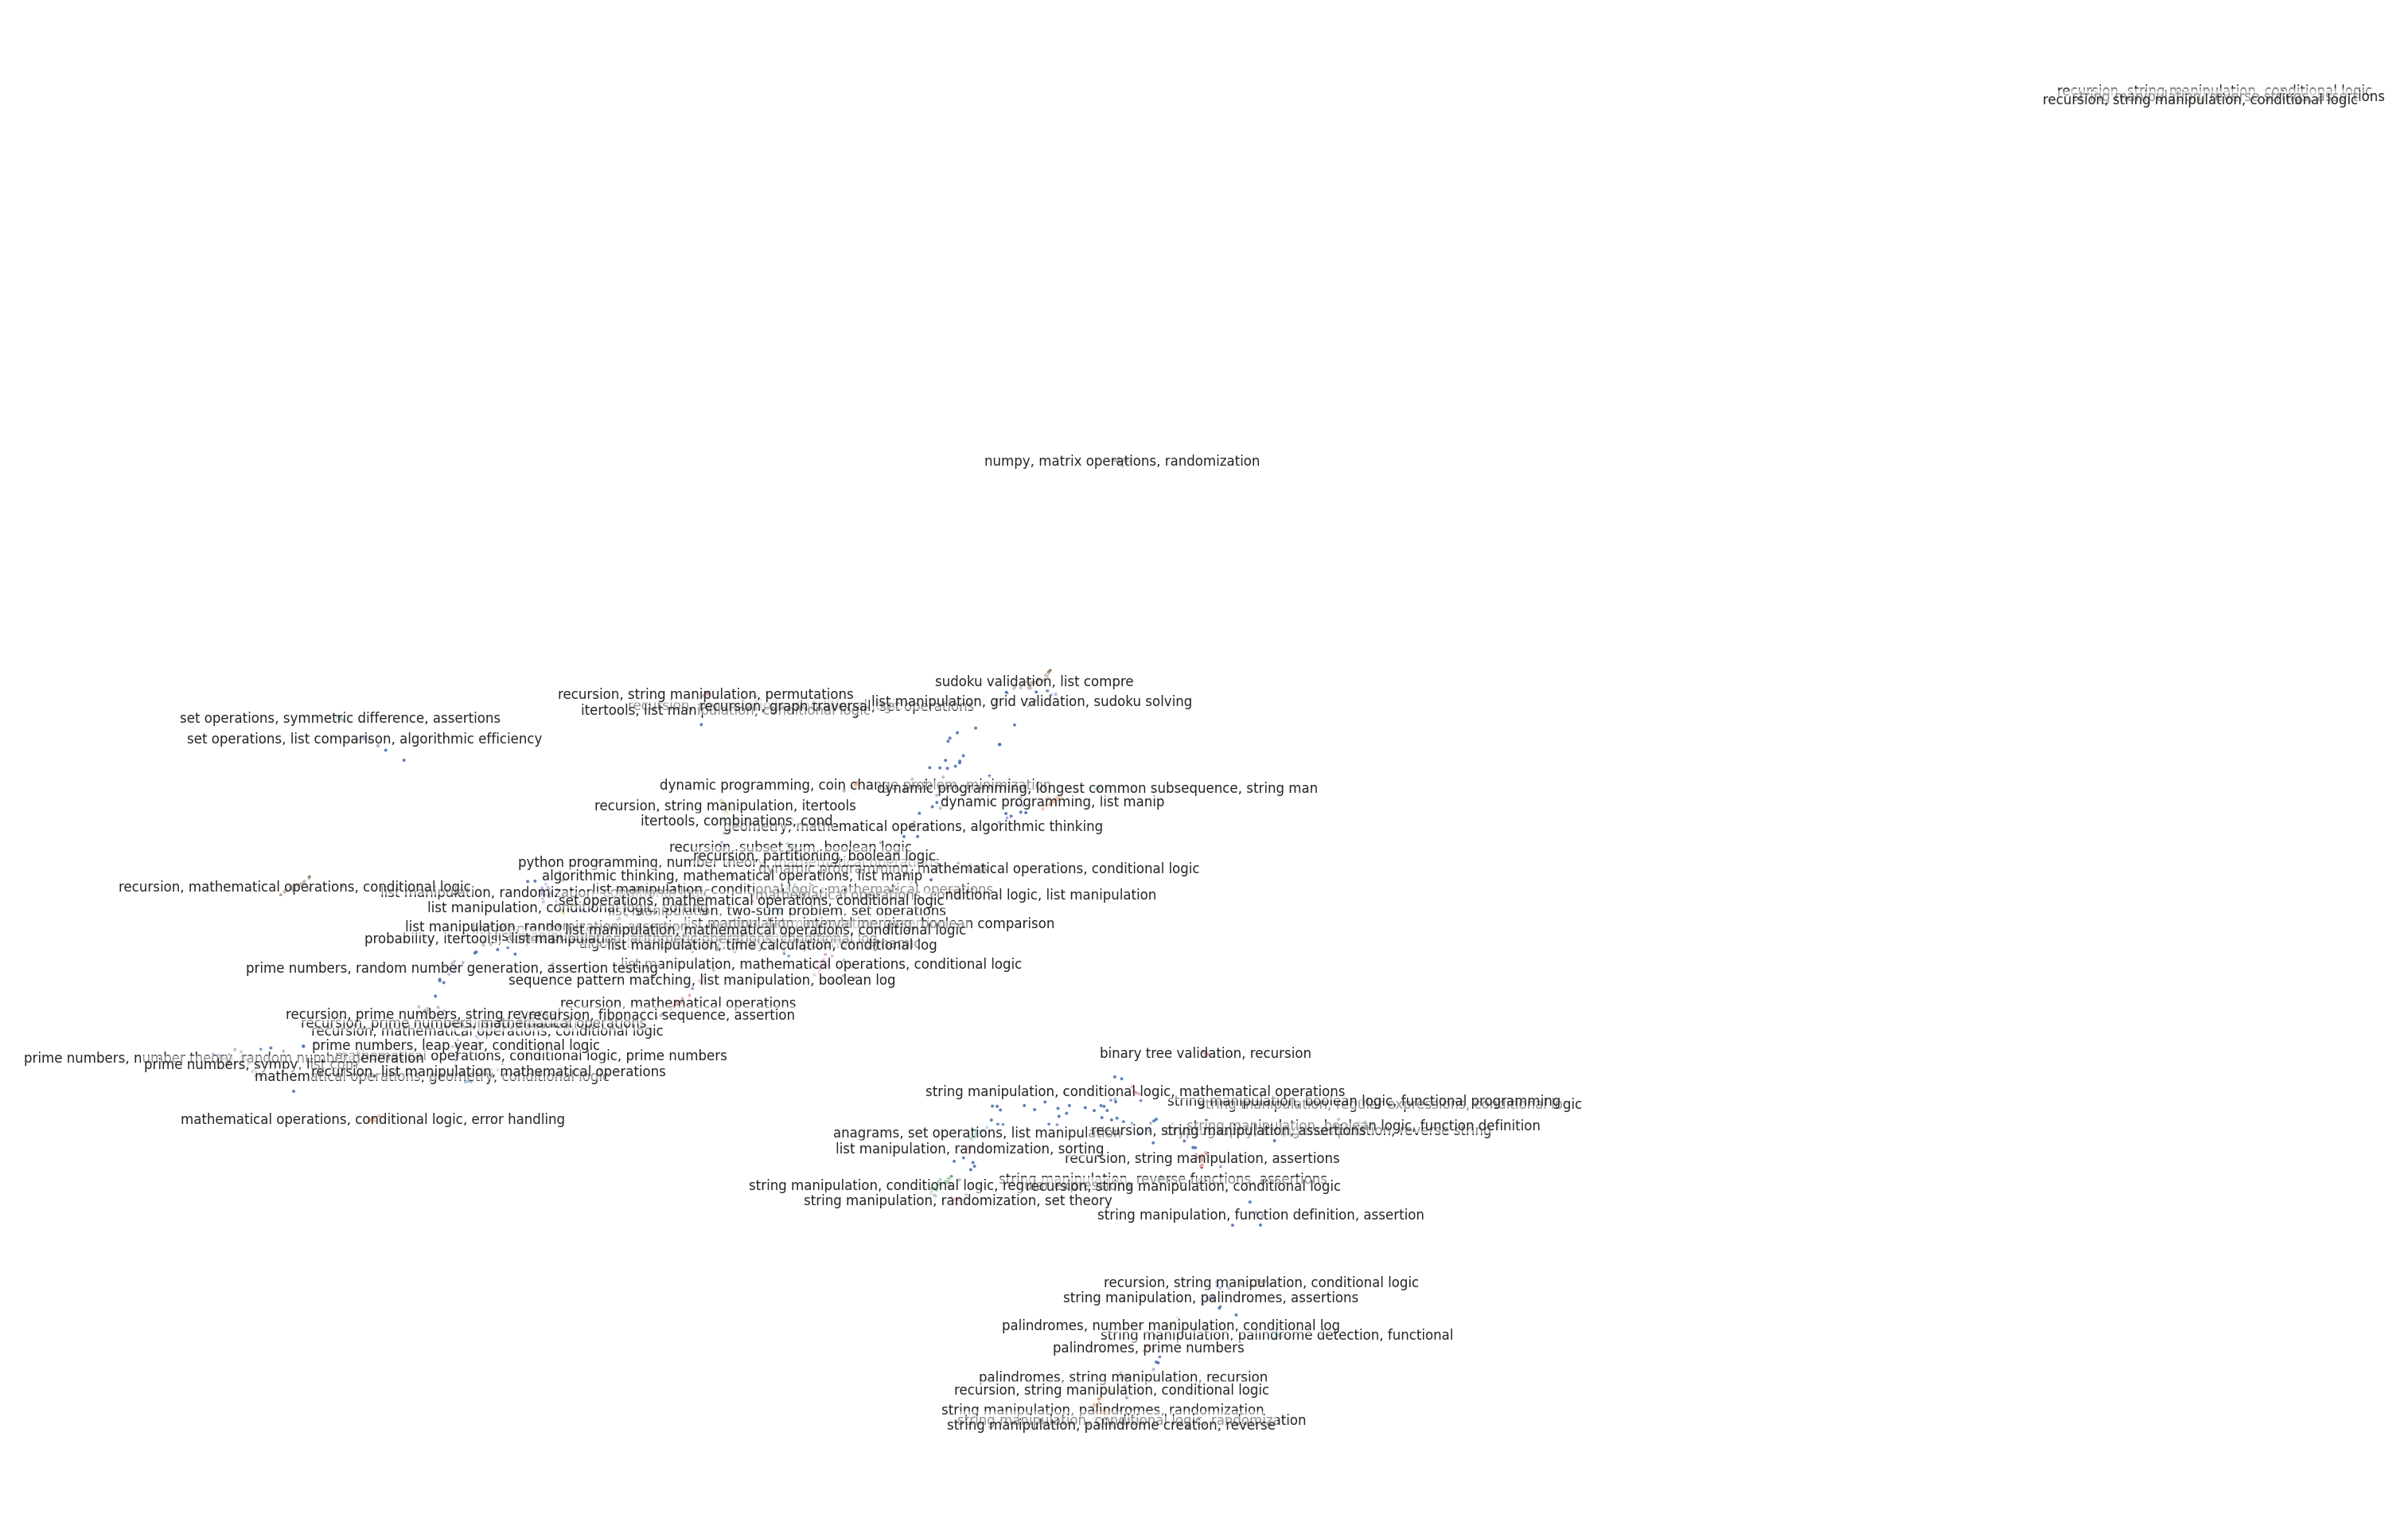

In [17]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

df["color"] = df["labels"].apply(lambda x: "C0" if x==-1 else f"C{(x%9)+1}")

df.plot(
    kind="scatter",
    x="X",
    y="Y",
    # c="labels",
    s=0.9,
    alpha=0.9,
    linewidth=0.,
    color=df["color"],
    ax=ax,
    colorbar=False,
)

for label in cc.cluster_summaries.keys():
    if label == -1:
        continue
    summary = cc.cluster_summaries[label]
    position = cc.cluster_centers[label]
    t= ax.text(
        position[0],
        position[1],
        summary.split("Educational")[0],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=4,
    )
    t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0, boxstyle='square,pad=0.1'))
ax.set_axis_off()
plt.show()

# test vllm 

In [1]:
from vllm import LLM, SamplingParams

prompt_template='''<s>[INST] {prompt} [/INST]
'''
# Sample prompts.
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95,prompt_logprobs=True)

# Create an LLM.# "TheBloke/deepseek-coder-6.7B-instruct-AWQ", heyholetsgo/Nous-Hermes-2-Mistral-7B-DPO-AWQ
llm = LLM(model="heyholetsgo/Nous-Hermes-2-Mistral-7B-DPO-AWQ", quantization="AWQ", dtype="auto", max_model_len = 6000)
# Generate texts from the prompts. The output is a list of RequestOutput objects
# that contain the prompt, generated text, and other information.
# outputs = llm.generate(prompts, sampling_params)
# # Print the outputs.
# for output in outputs:
#     prompt = output.prompt
#     generated_text = output.outputs[0].text
#     print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

WARNING 03-10 18:04:20 config.py:177] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 03-10 18:04:20 llm_engine.py:72] Initializing an LLM engine with config: model='heyholetsgo/Nous-Hermes-2-Mistral-7B-DPO-AWQ', tokenizer='heyholetsgo/Nous-Hermes-2-Mistral-7B-DPO-AWQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=6000, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 03-10 18:04:25 weight_utils.py:164] Using model weights format ['*.safetensors']
INFO 03-10 18:04:33 llm_engine.py:322] # GPU blocks: 4520, # CPU blocks: 2048
INFO 03-10 18:04:34 model_runner.py:632] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 03-10 18:04:34 model_runner.py:636] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 03-10 18:04:42 model_runner.py:698] Graph capturing finished in 7 secs.


## test function calling + vllm

In [38]:
from pydantic import BaseModel

# from outlines.serve.vllm import JSONLogitsProcessor # error with that see below
#

class User(BaseModel):
    name: str
    age: int




In [24]:
import json
import math
from collections import defaultdict
from typing import DefaultDict, Dict, List, Optional

import torch
from pydantic import BaseModel

from outlines.fsm.fsm import RegexFSM
from outlines.fsm.json_schema import build_regex_from_schema


class RegexLogitsProcessor:
    def __init__(self, regex_string, llm):
        """Compile the FSM that drives the regex-structured generation.

        Parameters
        ----------
        regex_string
            A string that represents a regular expression
        llm
            An instance of `vllm.LLM`

        """
        if hasattr(llm, "get_tokenizer"):
            tokenizer = llm.llm_engine.tokenizer.tokenizer#llm.get_tokenizer()
        elif hasattr(llm, "tokenizer"):
            if hasattr(llm.tokenizer, "tokenizer"):
                tokenizer = llm.tokenizer.tokenizer
            else:
                tokenizer = llm.tokenizer
        else:
            raise ValueError(
                "The provided LLM instance in `RegexLogitsProcessor` neither has a "
                "`tokenizer` attribute or a `get_tokenizer` method."
            )
        tokenizer = self.adapt_tokenizer(tokenizer=tokenizer)

        fsm = RegexFSM(regex_string, tokenizer)
        self.fsm = fsm

    def __call__(self, input_ids: List[int], scores: torch.Tensor) -> torch.Tensor:
        """Use the FSM to bias the logits before sampling the next token."""

        seq_id = hash(tuple(input_ids))

        if len(input_ids) == 0:  # Initialize the fsm states
            self.fsm_state: DefaultDict[int, int] = defaultdict(int)
        else:
            last_token = input_ids[-1]
            last_seq_id = hash(tuple(input_ids[:-1]))
            self.fsm_state[seq_id] = self.fsm.next_state(
                self.fsm_state[last_seq_id], last_token
            )

        allowed_tokens = self.fsm.allowed_token_ids(self.fsm_state[seq_id])

        mask = torch.full((scores.shape[-1],), -math.inf, device=scores.device)
        mask[allowed_tokens] = 0
        biased_scores = scores + mask

        return biased_scores

    def adapt_tokenizer(self, tokenizer):
        """Adapt vLLM's tokenizer to use to compile the FSM.

        The API of Outlines tokenizers is slightly different to that of
        `transformers`. In addition we need to handle the missing spaces to
        Llama's tokenizer to be able to compile FSMs for this model.

        """
        tokenizer.vocabulary = tokenizer.get_vocab()
        tokenizer.special_tokens = set(tokenizer.all_special_tokens)

        def convert_token_to_string(token: str) -> str:
            from transformers.file_utils import SPIECE_UNDERLINE

            string = tokenizer.convert_tokens_to_string([token])

            # A hack to handle missing spaces to HF's Llama tokenizers
            if token.startswith(SPIECE_UNDERLINE) or token == "<0x20>":
                return " " + string

            return string

        tokenizer.convert_token_to_string = convert_token_to_string

        return tokenizer


class JSONLogitsProcessor(RegexLogitsProcessor):
    def __init__(self, schema: Dict, llm, whitespace_pattern: Optional[str] = None):
        """Compile the FSM that drives the JSON-guided generation.

        Parameters
        ----------
        schema
            A JSON schema that encodes the structure we want the model to generate
        llm
            An instance of `vllm.LLM`
        whitespace_pattern
            Pattern to use for JSON syntactic whitespace (doesn't impact string literals)
            Example: allow only a single space or newline with `whitespace_pattern=r"[\n ]?"`
        """
        if isinstance(schema, type(BaseModel)):
            schema_str = json.dumps(schema.model_json_schema())
        elif isinstance(schema, Dict):
            schema_str = json.dumps(schema)
        elif isinstance(schema, str):
            schema_str = schema
        else:
            raise ValueError(
                f"Cannot parse schema {schema}. The schema must be either "
                + "a Pydantic object, a dictionary or a string that contains the JSON "
                + "Schema specification"
            )
        regex_string = build_regex_from_schema(schema_str, whitespace_pattern)
        super().__init__(regex_string, llm)


In [39]:
logits_processor = JSONLogitsProcessor(schema=User, llm=llm)

In [42]:
prompts=["Jenna, 26 years old", "Mike 16 years old"]
result = llm.generate(
    prompts,
    sampling_params=SamplingParams(
        max_tokens=100, logits_processors=[logits_processor]
    ),
)
print(result)

Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

[RequestOutput(request_id=4, prompt='Jenna, 26 years old', prompt_token_ids=[1, 11654, 1520, 28725, 28705, 28750, 28784, 1267, 1571], prompt_logprobs=None, outputs=[CompletionOutput(index=0, text='{\n\n      "sexe": "feminine",\n      "name": "Jenna",\n      "age":26\n    }', token_ids=[28751, 13, 13, 355, 345, 28713, 720, 28706, 1264, 345, 26857, 262, 473, 548, 13, 355, 345, 28711, 433, 1264, 345, 28798, 269, 1520, 548, 13, 355, 345, 465, 1264, 28750, 28784, 13, 2287, 443, 32000], cumulative_logprob=-17.719579146995102, logprobs=None, finish_reason=stop)], finished=True, lora_request=None), RequestOutput(request_id=5, prompt='Mike 16 years old', prompt_token_ids=[1, 9360, 28705, 28740, 28784, 1267, 1571], prompt_logprobs=None, outputs=[CompletionOutput(index=0, text='{ \n\n"sexe": "masculin",\n"name": "mike",\n"age": 16\n}', token_ids=[28751, 28705, 13, 13, 28739, 28713, 720, 28706, 1264, 345, 4876, 2320, 262, 548, 13, 28739, 861, 1264, 345, 28719, 2474, 548, 13, 28739, 465, 1264, 287

In [44]:
for i in range(len(prompts)):
    print("prompt: ",result[i].prompt)

    print("output :\n",result[i].outputs[0].text)

prompt:  Jenna, 26 years old
output :
 {

      "sexe": "feminine",
      "name": "Jenna",
      "age":26
    }
prompt:  Mike 16 years old
output :
 { 

"sexe": "masculin",
"name": "mike",
"age": 16
}


## test educational values

In [1]:
from datasets import Dataset, load_dataset
import json
path="/home/flowers/work/text-clustering/archive/maps_1_imgep_smart.json"

with open(path, encoding="utf-8") as f:
    dataset = json.load(f)
to_remove=["emb","target_skills","puzzle_history","quality","description","is_valid","is_valid_explanation"]
for i in dataset:
    for j in to_remove:
        if j in i:
            del i[j]
from datasets import Dataset

dataset = Dataset.from_list(dataset).shuffle(
    seed=42
)
# ds = load_dataset("json", data_files=path, split="train", token=True).shuffle(
#     seed=42
# )

print(dataset)

Dataset({
    features: ['fitness', 'program_str', 'explanation_emb', 'idx_generation', 'problem_func', 'solution_func', 'pass_5', 'n_sample', 'n_correct', 'yes_finetuning_deepseek-1.3b', 'judgeLM-7b-abs_finetuning', 'OpenCodeInterpreter-1-gpt35-abs_finetuning', 'OpenCodeInterpreter-2-gpt35-abs_finetuning'],
    num_rows: 961
})


In [3]:
from run_pipeline import main
main()

aces_test  cc_100k   LICENSE	run_pipeline.py  test.ipynb
archive    examples  README.md	src


In [6]:
import json
path="/home/flowers/work/text-clustering/archive/maps_1_imgep_smart.json"
with open(path) as f:
    data = json.load(f)
INSTRUCTION_SINGLE_TOPIC = "The examples below are Python Programming Puzzles from the same cluster, identify the topic they have in common, for example: String Manipulation, Mathematical Operations, Conditional Logic, ...\n\
Additionally determine if the topics in the examples \
are broadly suitable as bachelor CS material.\n\
Consider a specific range of leetcode type puzzle, \
give a rating of how educational these puzzles could be from 1 to 10, 1 being extremely un-educational \
and inapproriate for an education setting and 10 being highly educational.\nThe output format should be like this: Topic: the_topic, Educational value rating: score."
# mistral
TEMPLATE_SINGLE_TOPIC_mistral = "<s>[INST]{instruction}\n\nExamples:\n{examples}\n\nRemember that the output format **must** be like this: Topic: the_topic, Educational value rating: score.[/INST]"
TEMPLATE_SINGLE_TOPIC_chatml = """<|im_start|>system
You are a sentient, superintelligent artificial general intelligence, here to teach and assist me.<|im_end|>
<|im_start|>user
{instruction}\n\nExamples:\n{examples}\n\nRemember that the output format **must** be like this: Topic: the_topic, Educational value rating: score.<|im_end|>
<|im_start|>assistant"""
#deepseek
TEMPLATE_SINGLE_TOPIC_deepseek='''You are an AI programming assistant, utilizing the Deepseek Coder model, developed by Deepseek Company.
### Instruction:
{instruction}\n\nExamples:\n{examples}\n\nRemember that the output format **must** be like this: Topic: the_topic, Educational value rating: score.
### Response:
'''



ids=[0,1]
examples = "\n\n".join(
    [
        f"Example {i+1}:\n{data[_id]['program_str']}"
        for i, _id in enumerate(ids)
    ]
)

request = TEMPLATE_SINGLE_TOPIC_chatml.format(
    examples=examples, instruction=INSTRUCTION_SINGLE_TOPIC
)
print(request)

<|im_start|>system
You are a sentient, superintelligent artificial general intelligence, here to teach and assist me.<|im_end|>
<|im_start|>user
The examples below are Python Programming Puzzles from the same cluster, identify the topic they have in common, for example: String Manipulation, Mathematical Operations, Conditional Logic ...
Additionally determine if the topics in the examples are broadly suitable as bachelor material.
Consider a specific range of leetcode type puzzle, give a rating of how educational these puzzles could be from 1 to 10, 1 being extremely un-educational and inapproriate for an education setting and 10 being highly educational.
The output format should be like this: Topic: the_topic, Educational value rating: score.

Examples:
Example 1:
def f(n: int) -> bool:
    return str(n * n).startswith('123456789')
def g():
    return int(int("123456789" + "0" * 9) ** 0.5) + 1
assert f(g()) == True

Example 2:
def f(s: str) -> bool:
    return s.count('o') == 1000 and

In [7]:

sampling_params = SamplingParams(temperature=0.01, top_p=0.95)#,prompt_logprobs=1,logprobs=1)
outputs = llm.generate([request], sampling_params)
# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, \nGenerated text: {generated_text!r}")

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]

Prompt: '<|im_start|>system\nYou are a sentient, superintelligent artificial general intelligence, here to teach and assist me.<|im_end|>\n<|im_start|>user\nThe examples below are Python Programming Puzzles from the same cluster, identify the topic they have in common, for example: String Manipulation, Mathematical Operations, Conditional Logic ...\nAdditionally determine if the topics in the examples are broadly suitable as bachelor material.\nConsider a specific range of leetcode type puzzle, give a rating of how educational these puzzles could be from 1 to 10, 1 being extremely un-educational and inapproriate for an education setting and 10 being highly educational.\nThe output format should be like this: Topic: the_topic, Educational value rating: score.\n\nExamples:\nExample 1:\ndef f(n: int) -> bool:\n    return str(n * n).startswith(\'123456789\')\ndef g():\n    return int(int("123456789" + "0" * 9) ** 0.5) + 1\nassert f(g()) == True\n\nExample 2:\ndef f(s: str) -> bool:\n    re

In [18]:
def _postprocess_response( response):

        first_line = response.split("\n")[0]
        topic, score = None, None
        for line in response.split("\n"):
            if topic == None:
                try:
                    topic = line.lower().split("Topic:".lower())[1].split("(")[0].split(",")[0].strip()
                except IndexError:
                    # print("No topic found")
                    pass
            if score == None:
                try:
                    score = line.lower().split("Educational value rating:".lower())[1].strip().split(".")[0].strip()
                except IndexError:
                    # print("No educational score found")
                    pass
        full_output = f"{topic}. Educational score: {score}"
        return full_output
        # for line in response.split("\n"):
        # try:
        #     topic = first_line.split("Topic:")[1].split("(")[0].split(",")[0].strip()
        # except IndexError:
        #     print("No topic found")
        # try:
        #     score = first_line.split("Educational value rating:")[1].strip().split(".")[0].strip()
        # except IndexError:
        #     print("No educational score found")
        # full_output = f"{topic}. Educational score: {score}"
        # return full_output

In [19]:
_postprocess_response(generated_text)

'string manipulation. Educational score: 8'

In [17]:
generated_text.split("\n")

['', 'Topic: String Manipulation, Educational value rating: 8.']

In [15]:
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")



Prompt: '<s>[INST] The future of AI is [/INST]\n', Generated text: '\nThe future of AI (Artificial Intelligence) is a topic of much debate'
Prompt: '<s>[INST] The future of AI is [/INST]\n', Generated text: '\nThe future of AI (Artificial Intelligence) is an area of much debate'
Prompt: '<s>[INST] The future of AI is [/INST]\n', Generated text: '\nThe future of AI (Artificial Intelligence) is a topic of much debate'
Prompt: '<s>[INST] The future of AI is [/INST]\n', Generated text: '\nThe future of AI (Artificial Intelligence) is a topic of much debate'
